In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Markdown as md

from tsfresh.feature_extraction import settings
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute, make_forecasting_frame, roll_time_series
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters, settings

from sklearn.metrics import max_error as ME,mean_absolute_error as MAE, mean_absolute_percentage_error as MAPE


mypath = './Datasets/wisabi'
files = [join(mypath, f) for f in listdir(mypath) if isfile(
    join(mypath, f)) and "transactions.csv" in f]
files

['./Datasets/wisabi/enugu_transactions.csv',
 './Datasets/wisabi/fct_transactions.csv',
 './Datasets/wisabi/kano_transactions.csv',
 './Datasets/wisabi/lagos_transactions.csv',
 './Datasets/wisabi/rivers_transactions.csv']

In [2]:
dfs = list(zip(map(pd.read_csv, files), files))
def transactions_to_cash_ts(args):
    df, file = args
    for c in ['TransactionStartDateTime','TransactionEndDateTime']:
        df[c] = pd.to_datetime(df[c])
    df = df.drop(columns=['CardholderID',	'LocationID'])
    df= df[df.TransactionTypeID.isin([1,2])]#.drop(columns='TransactionTypeID')
    df['date'] = df.TransactionStartDateTime.dt.date
    df.drop(columns=['TransactionStartDateTime','TransactionEndDateTime'], inplace=True)
    df.loc[df.TransactionTypeID==2, 'TransactionAmount']*=(-1)
    df = df.drop(columns='TransactionTypeID')
    ts = df.groupby('date').sum().TransactionAmount
    ts.name=file.split('/')[-1].split('.')[0]
    return ts

tss = list(map(transactions_to_cash_ts,dfs))


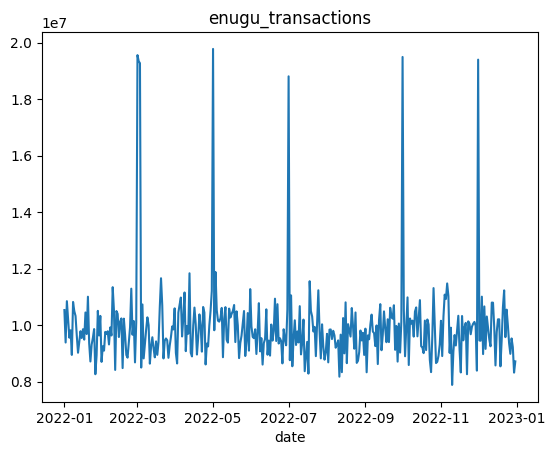

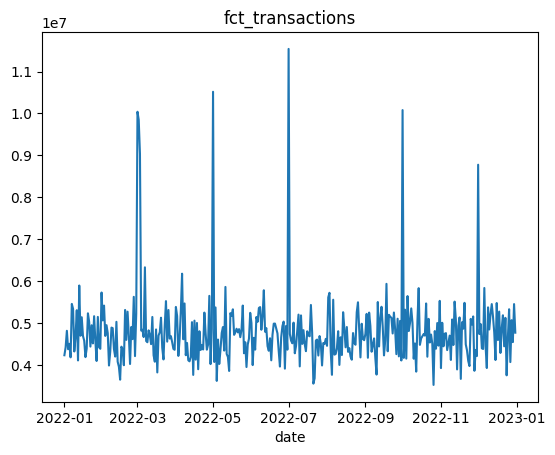

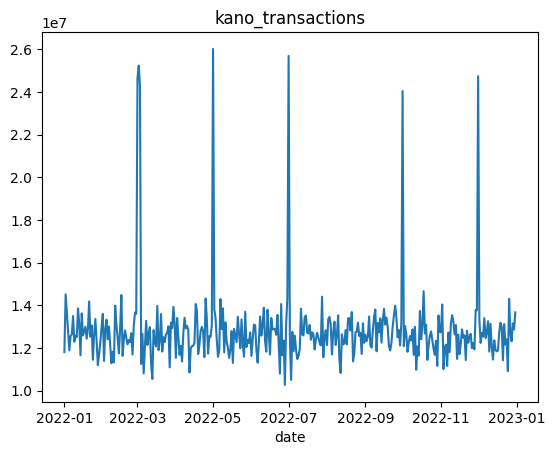

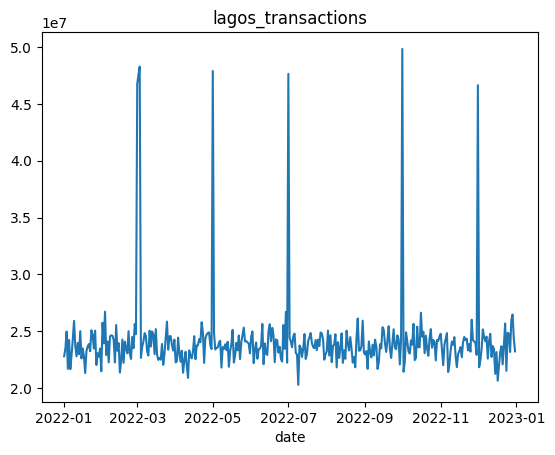

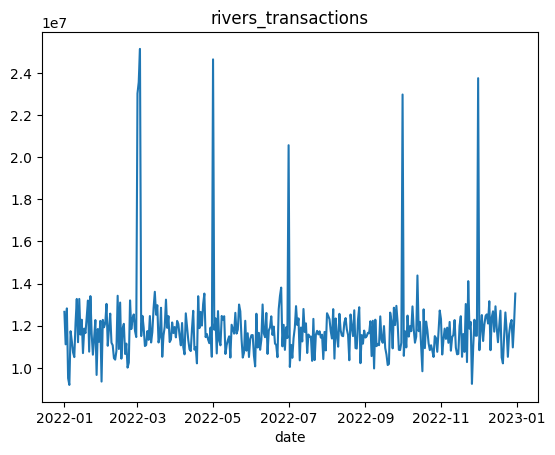

In [3]:
for ts in tss:
    ts.plot()
    plt.title(ts.name)
    plt.show()

In [4]:
ts = tss[0].diff().dropna()
med = ts.median()#TODO более аккуратно
ts.loc[ts.sort_values().head(7).index] = med
ts.loc[ts.sort_values().tail(7).index] = med

In [5]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ts.index, y=ts))

In [6]:
dfts = ts.to_frame()
dfts['id'] = ts.name
dfts.reset_index(inplace=True)
dfts

,date,enugu_transactions,id
0,2022-01-02,-1150000.0,enugu_transactions
1,2022-01-03,1464000.0,enugu_transactions
2,2022-01-04,-644000.0,enugu_transactions
3,2022-01-05,-649000.0,enugu_transactions
4,2022-01-06,262000.0,enugu_transactions
...,...,...,...
359,2022-12-27,-373000.0,enugu_transactions
360,2022-12-28,545000.0,enugu_transactions
361,2022-12-29,-308000.0,enugu_transactions
362,2022-12-30,-902000.0,enugu_transactions


In [7]:
df_rolled = roll_time_series(dfts, column_id="id", column_sort="date",
                             max_timeshift=20, min_timeshift=5)
#каждый момент времени описываем окном длины не больше 20, окна длины меньше чем 5 отбрасываем

Rolling: 100%|██████████| 20/20 [00:00<00:00, 47.11it/s]


In [8]:
df_rolled

,date,enugu_transactions,id
0,2022-01-02,-1150000.0,"(enugu_transactions, 2022-01-07)"
1,2022-01-03,1464000.0,"(enugu_transactions, 2022-01-07)"
2,2022-01-04,-644000.0,"(enugu_transactions, 2022-01-07)"
3,2022-01-05,-649000.0,"(enugu_transactions, 2022-01-07)"
4,2022-01-06,262000.0,"(enugu_transactions, 2022-01-07)"
...,...,...,...
6217,2022-12-27,-373000.0,"(enugu_transactions, 2022-12-31)"
6218,2022-12-28,545000.0,"(enugu_transactions, 2022-12-31)"
6219,2022-12-29,-308000.0,"(enugu_transactions, 2022-12-31)"
6220,2022-12-30,-902000.0,"(enugu_transactions, 2022-12-31)"


In [9]:
# extraction_settings = EfficientFCParameters()
# extraction_settings = ComprehensiveFCParameters()
# del extraction_settings["friedrich_coefficients"]
# del extraction_settings["max_langevin_fixed_point"]
extraction_settings = MinimalFCParameters()

In [10]:
name = ts.name
X = extract_features(df_rolled, 
                     column_id="id", column_sort="date", column_value=name, 
                     impute_function=impute, show_warnings=False,
                     default_fc_parameters=extraction_settings)

Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 62.00it/s]


In [11]:
horizon = 1
X.set_index(X.index.map(lambda x: x[0][1]), inplace=True)


In [24]:
X[name] = ts[X.index] # добавялем оригинальный ряд
X['y'] = X[name].shift(-horizon) 
# добавляем target - оригинальный ряд смещенный на 1 в будущее
df = X.dropna()
y = df.y
df.drop('y', axis=1, inplace=True )
X= df

/tmp/ipykernel_15785/3174652478.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


In [14]:
# X_train_selected = select_features(X_train, y_train)
# best_features=X_train_selected.columns
# md(f"#### Отобрали фичей: {len(best_features)}")


In [15]:
from catboost import CatBoostRegressor


# model = CatBoostRegressor(silent=True).fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_test), index=X_test.index)

In [16]:
y_pred_dumb = y_test.shift(1)

In [17]:
MAE(y_test[1:],y_pred_dumb[1:])

1372224.2990654206

In [18]:
MAE(y_test, y_pred)

771396.3259629488

In [19]:
fig = go.Figure()
fig.update_layout(title_text=f"CatBoost & tsfresh. MAPE={MAPE(y_test, y_pred):.4f}")
fig.add_trace(go.Scatter(x=y_train.index, y=y_train, name="Train"))
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, name="Test"))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred, name="Predicted"))

### Torch

In [20]:
###

In [27]:
from datasets import load_dataset, load_from_disk
import pandas as pd
from transformers import Trainer
from transformers import TrainingArguments
from transformers import EncoderDecoderModel
from transformers import BertTokenizer
import numpy as np
import os
import random
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import shutil 
from tqdm import tqdm
torch.cuda.empty_cache()
gc.collect()

SEED = 42


def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


torch.backends.cudnn.deterministic = True
seed_everything(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
dfX_train = X_train
dfX_test = X_test
dfy_train = y_train
dfy_test = y_test

X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

In [79]:
feat_cnt = X.shape[1]
model = nn.Sequential(
    nn.Linear(feat_cnt, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

In [80]:
lossFunction = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [81]:
import copy


epochs = 400   # number of epochs to run
batchSize = 20  # size of each batch

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

size = X.shape[0]
# my redone training loop
for epoch in range(epochs):
    model.train()

    index = 0

    while index * batchSize <= size:
        # take a batch
        X_batch = X_train[index:index + batchSize]
        y_batch = y_train[index:index + batchSize]

        # forward pass
        y_pred = model(X_batch)

        # print(y_pred)
        loss = lossFunction(y_pred, y_batch)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()

        index += batchSize

    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = lossFunction(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        print(f"best mse is {mse} on epoch {epoch}")
        best_mse = mse

        # save the best weights
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)

best mse is 1.2063001553074651e+19 on epoch 0
best mse is 4.30731701060318e+18 on epoch 1
best mse is 5.820127362678784e+17 on epoch 2
best mse is 1.592821950667817e+17 on epoch 3
best mse is 1.1546631954497536e+16 on epoch 11
best mse is 4876681424666624.0 on epoch 20
best mse is 2460745946103808.0 on epoch 29
best mse is 588214897213440.0 on epoch 38
best mse is 49530548518912.0 on epoch 46
best mse is 1587435274240.0 on epoch 54
best mse is 1078699229184.0 on epoch 97
best mse is 1045235367936.0 on epoch 123
best mse is 1039505031168.0 on epoch 165
best mse is 1039214903296.0 on epoch 194


<All keys matched successfully>

Text(0, 0.5, 'Epoch')

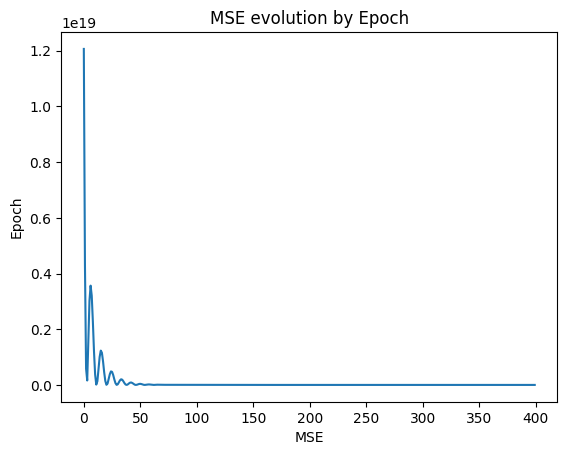

In [82]:
plt.plot(history)
plt.title("MSE evolution by Epoch")
plt.xlabel("MSE")
plt.ylabel("Epoch")

In [83]:
dfy_pred = pd.Series(model(X_test).detach().numpy().reshape(-1), index = dfy_test.index)

In [84]:
fig = go.Figure()
fig.update_layout(title_text=f"NNet & tsfresh. MAPE={MAPE(dfy_test, dfy_pred):.4f}")
fig.add_trace(go.Scatter(x=dfy_train.index, y=dfy_train, name="Train"))
fig.add_trace(go.Scatter(x=dfy_test.index, y=dfy_test, name="Test"))
fig.add_trace(go.Scatter(x=dfy_pred.index, y=dfy_pred, name="Predicted"))